# Assignment 01 - Fine-tuning DETR for Balloon Detection 
**By Grozny_Sergey**

In [137]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
import torchvision, os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random, torch
import numpy as np
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm
from coco_eval import CocoEvaluator ## Library for MAP calculate

In [138]:
import warnings
warnings.filterwarnings('ignore')

## Data preparation 

In [139]:
def dataframe_to_coco(df, output_path, category_name="object", category_id=1):
    """
    Converts a dataframe to a COCO JSON format.

    Args:
        df (pd.DataFrame): Input dataframe with fields ['fname', 'height', 'width', 'bbox', 'num_balloons'].
        output_path (str): Path to save the output COCO JSON file.
        category_name (str): Name of the category (default: "object").
        category_id (int): ID of the category (default: 1).

    Returns:
        None: Saves the COCO JSON file to the specified output path.
    """
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [{"id": category_id, "name": category_name, "supercategory": "none"}]
    }

    annotation_id = 1  # Unique ID for each annotation
    for idx, row in df.iterrows():
        image_id = idx + 1  # Unique ID for each image

        # Add image information
        coco_format["images"].append({
            "id": image_id,
            "file_name": row["fname"],
            "height": row["height"],
            "width": row["width"]
        })

        # Add annotations
        for bbox in eval(row["bbox"]):
            # Convert bbox to COCO format: [x, y, width, height]
            coco_bbox = [
                bbox["xmin"],
                bbox["ymin"],
                bbox["xmax"] - bbox["xmin"],
                bbox["ymax"] - bbox["ymin"]
            ]

            coco_format["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": coco_bbox,
                "area": coco_bbox[2] * coco_bbox[3],  # width * height
                "iscrowd": 0
            })
            annotation_id += 1

    # Save to JSON file
    with open(output_path, "w") as f:
        json.dump(coco_format, f, indent=4)

    print(f"COCO JSON saved to {output_path}")

In [140]:
df = pd.read_csv('balloon-data.csv')
ann_name = 'annotations.json'
dataframe_to_coco(df, ann_name)

COCO JSON saved to annotations.json


In [141]:
ANNOTATION_FILE_NAME = "annotations.json"

In [142]:
from transformers import DetrForObjectDetection, DetrImageProcessor
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [222]:
class Coco(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        processor, 
        transform = None
    ):
        super().__init__(image_directory_path, ANNOTATION_FILE_NAME, transform=transform)
        self.processor = processor
    def __getitem__(self, idx):
        image, annotations = super().__getitem__(idx)        
        image_id = self.ids[idx]
        image = np.asarray(image)
        if self.transform is not None:
                bboxes = [anno['bbox'] for anno in annotations]
                category_ids = [anno['category_id'] for anno in annotations]
                transformed = self.transform(
                    image=image,
                    bboxes=bboxes,
                    class_labels=category_ids
                )
            
                # Extract transformed bboxes and category_ids
                transformed_bboxes = transformed['bboxes']
                transformed_category_ids = transformed['class_labels']
                print(transformed_bboxes)
                # Update the annotations
                annotations = []
                for idd, bbox in enumerate(transformed_bboxes):
                    # Calculate area
                    x, y, w, h = bbox
                    area = w * h
            
                    # Recreate the annotation with the same id
                    annotations.append({
                        'id': idx,
                        'image_id': image_id,
                        'category_id': transformed_category_ids[idd],
                        'bbox': [x, y, w, h],
                        'area': area,
                        'iscrowd': 0,
                    })
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.processor(images=image, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [210]:
def set_seed():
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [211]:
from torch.utils.data import random_split

full_dataset = Coco(image_directory_path='images/', processor=processor)


train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

set_seed()
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train size: 51
Validation size: 11
Test size: 12


In [146]:
cats = train_dataset.dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
def show_image(dataset, image_id):
    image_ids = dataset.coco.getImgIds()
    image = dataset.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join('images', image['file_name']))
    annotations = dataset.coco.imgToAnns[image_id]
    draw = ImageDraw.Draw(image, "RGBA")
    for annotation in annotations:
      box = annotation['bbox']
      class_idx = annotation['category_id']
      x,y,w,h = tuple(box)
      draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
      draw.text((x, y), id2label[class_idx], fill='white')
    return image

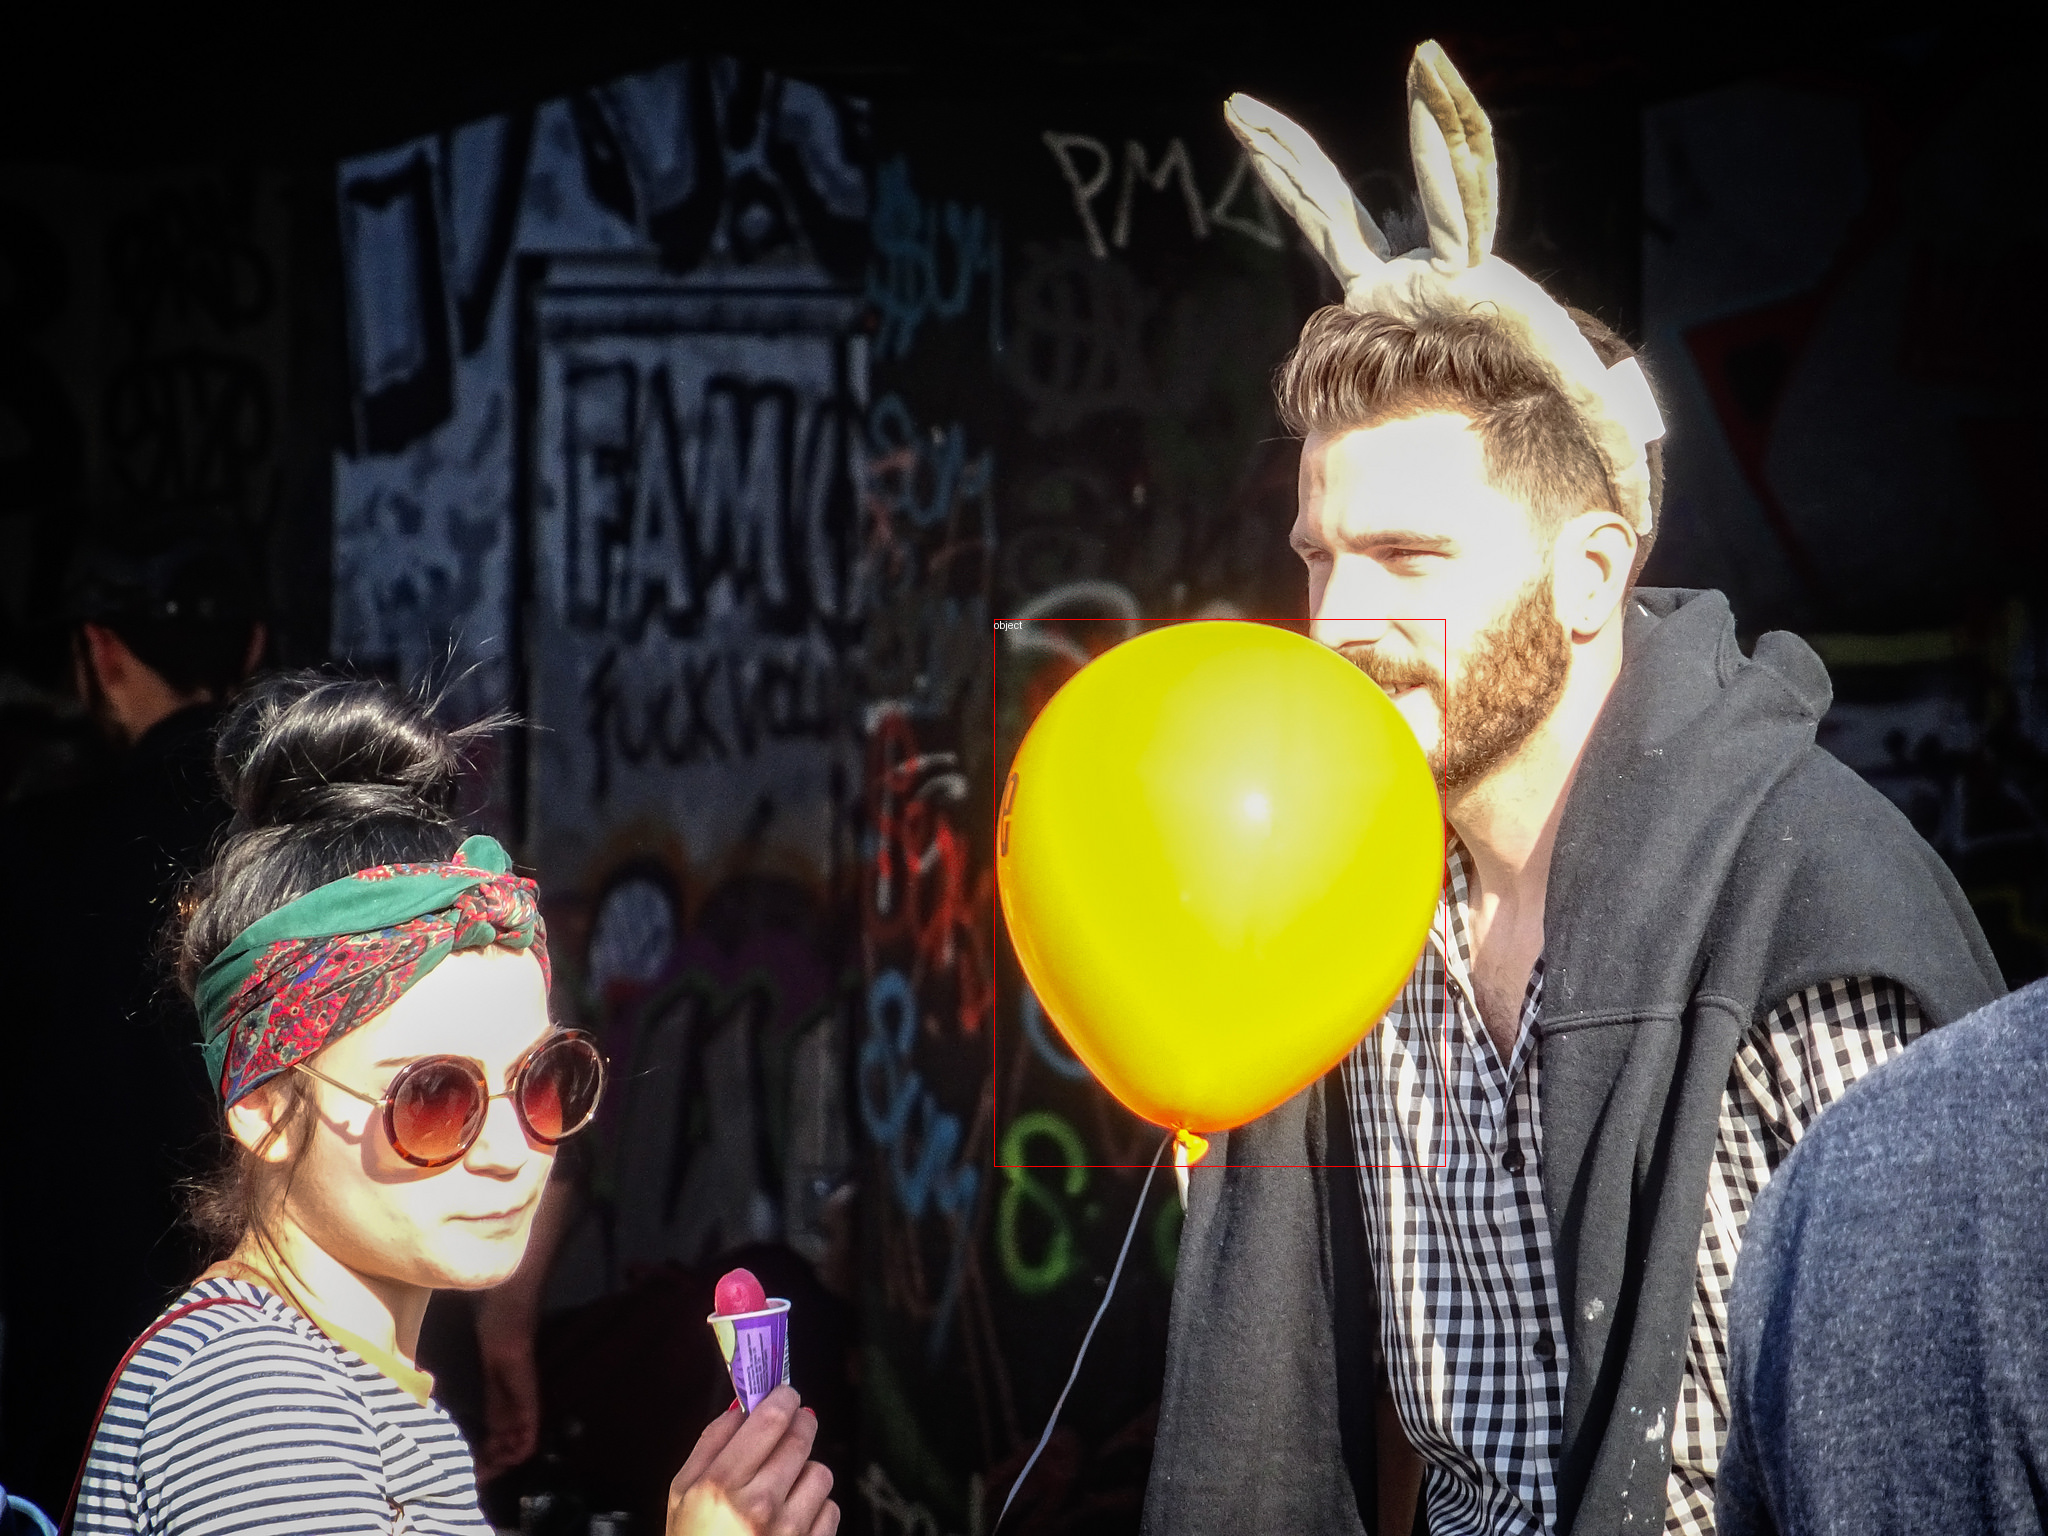

In [147]:
show_image(train_dataset.dataset, 1)

In [148]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

In [149]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

## Pytorch Lightning module

In [150]:

pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda")
class Detr(pl.LightningModule):

    def __init__(self, lr=5e-5, weight_decay=1e-4):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                            revision="no_timm",
                                                            #num_labels=1, 
                                                            ignore_mismatched_sizes=True)
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        
    def _calculate_loss(self, batch, batch_idx, mode):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        
        loss = outputs.loss
        loss_dict = outputs.loss_dict
        self.log(mode+"_loss", loss)
        
        for k,v in loss_dict.items():
            self.log(mode+"_"+k, v.item())
        return loss

    def training_step(self, batch, batch_idx):
        
        return self._calculate_loss(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):

        return self._calculate_loss(batch, batch_idx, "val")
            
    def test_step(self, batch, batch_idx):
        
        return self._calculate_loss(batch, batch_idx, "test")
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay) 
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler] 

    

Seed set to 42


## Train without augmentations

In [151]:
model = Detr(lr=5e-5, weight_decay=1e-4)

In [152]:
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=20, callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")])
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
18.1 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.099   Total estimated model params size (MB)
0         Modules in train mode
467       Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [153]:
print(f"Best checkpoint path:{trainer.checkpoint_callback.best_model_path}")

Best checkpoint path:/home/br0fire/Progs/Transformers_CV/lightning_logs/version_10/checkpoints/epoch=7-step=104.ckpt


## Evaluation

In [154]:
model = Detr.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [155]:
model.to(device);

In [156]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)
def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [157]:

evaluator = CocoEvaluator(coco_gt=val_dataset.dataset.coco, iou_types=["bbox"])
for batch in tqdm(val_loader):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)

    evaluator.update(predictions)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.96it/s]


In [158]:
evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.849
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.797
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.453
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [159]:

evaluator = CocoEvaluator(coco_gt=test_dataset.dataset.coco, iou_types=["bbox"])
for batch in tqdm(test_loader):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)

    evaluator.update(predictions)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.02it/s]


In [160]:
evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.672
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

## Visualization

In [161]:
pixel_values, target = test_dataset[3]
pixel_values = pixel_values.unsqueeze(0).to(device)

In [162]:
with torch.no_grad():
  outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [163]:
image_id = target['image_id'].item()
image = test_dataset.dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('images', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)

In [164]:
results = postprocessed_outputs[0]

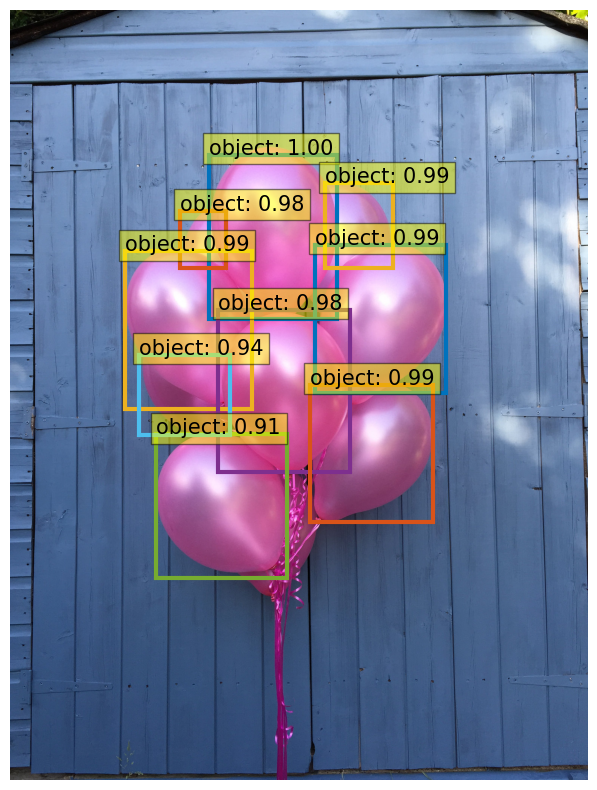

In [165]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show(),
plot_results(image, results['scores'], results['labels'], results['boxes'])

## Train with augmentations

In [212]:

from copy import copy

import albumentations as A


# Define the augmentation pipeline
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.5),
], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels']))

train_dataset.dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [168]:
model = Detr(lr=5e-5, weight_decay=1e-4)

In [ ]:
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=20, callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss")])
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
18.1 M    Trainable params
23.5 M    Non-trainable params
41.5 M    Total params
166.099   Total estimated model params size (MB)
0         Modules in train mode
467       Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [180]:
print(f"Best checkpoint path:{trainer.checkpoint_callback.best_model_path}")

Best checkpoint path:/home/br0fire/Progs/Transformers_CV/lightning_logs/version_11/checkpoints/epoch=7-step=104.ckpt


In [181]:
model = Detr.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

In [182]:
model.to(device);

In [183]:
evaluator = CocoEvaluator(coco_gt=val_dataset.dataset.coco, iou_types=["bbox"])
for batch in tqdm(val_loader):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)

    evaluator.update(predictions)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.74it/s]


In [184]:
evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.521
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.249
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [185]:
evaluator = CocoEvaluator(coco_gt=test_dataset.dataset.coco, iou_types=["bbox"])
for batch in tqdm(test_loader):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)
    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)

    evaluator.update(predictions)


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


In [186]:
evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

In [187]:
pixel_values, target = test_dataset[3]
pixel_values = pixel_values.unsqueeze(0).to(device)

In [188]:
with torch.no_grad():
  # forward pass to get class logits and bounding boxes
  outputs = model(pixel_values=pixel_values, pixel_mask=None)
print("Outputs:", outputs.keys())

Outputs: odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'encoder_last_hidden_state'])


In [192]:
image_id = target['image_id'].item()
image = test_dataset.dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('images', image['file_name']))

# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.5)

In [193]:
results = postprocessed_outputs[0]

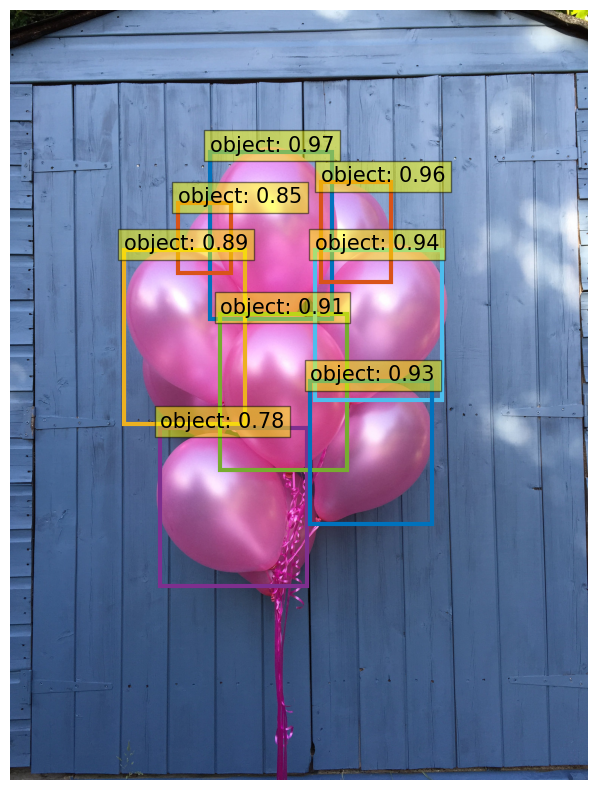

In [194]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
plot_results(image, results['scores'], results['labels'], results['boxes'])